### CONFIGURAÇÃO E IMPORTS

In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [21]:
MODEL_CONFIG = {
    "hidden_size": 33,      
    "num_layers": 3,       
    "dropout": 0.32245366199224057,         
    "output_horizon": 30,  
    "seq_len": 30,        
    "batch_size": 64,       
    "learning_rate": 0.0008841119953002912,
    "weight_decay": 0.0026533707797230786,    
    "epochs": 20           
}


step = 15

test_start = 153
test_end = 213 

### LEITURA E PRÉ-PROCESSAMENTO

In [22]:
print("Carregando dataset...")
ds = xr.open_dataset('/home/jovyan/CAP/Disciplinas/DeepLearning/TrabalhoFinal/Dados/ERA5_Derived_2010_2020.nc')

lat_min, lat_max = -25.50, -14.00
lon_min, lon_max = -53.00, -39.50
ds = ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))


ds["tp"] = ds["tp"] * 1000  #Converter de M para mm
del ds["sst"], ds["number"]

df = ds.to_dataframe().reset_index()
del ds

df["year"] = df["valid_time"].dt.year
df["month"] = df["valid_time"].dt.month
df["day"] = df["valid_time"].dt.dayofyear
df['valid_time'] = pd.to_datetime(df['valid_time'])

print("Shape:", df.shape)

Carregando dataset...


Shape: (10197684, 15)


In [23]:
def create_subseasonal_windows(data_x, data_y, seq_len=30, pred_horizon=30, step=step):
    """Gera janelas deslizantes (sliding windows) de entrada e saída."""
    X_list, y_list = [], []
    total_len = len(data_x)
    
    if total_len < (seq_len + pred_horizon):
        return np.array([]), np.array([])
    

    for i in range(0, total_len - seq_len - pred_horizon + 1, step):
        # Recorta a sequência de entrada (histórico)
        x_window = data_x[i : i + seq_len]
        # Recorta a sequência alvo (futuro imediato após a entrada)
        y_window = data_y[i + seq_len : i + seq_len + pred_horizon]
        X_list.append(x_window)
        y_list.append(y_window)
        
    return np.array(X_list), np.array(y_list)

def prepare_data_subseasonal(df_full, years, features, target, 
                             seq_len=30, start_day=None, end_day=None, 
                             scaler_X=None, scaler_y=None, step=step):

    # Filtra pelos anos selecionados
    mask = df_full["year"].isin(years)
    
    # Filtra por intervalo de dias do ano (para recortes sazonais)
    if start_day is not None and end_day is not None:
        mask = mask & (df_full["day"].between(start_day, end_day))
        
    df_subset = df_full[mask].copy()
    
    # Ordena espacialmente e temporalmente
    df_subset = df_subset.sort_values(by=["latitude", "longitude", "year", "day"])
    
    # Agrupa por localização para processar cada ponto de grade como uma série independente
    grouped = df_subset.groupby(["latitude", "longitude"])
    all_X, all_y = [], []
    
    if scaler_X is None:
        scaler_X = StandardScaler()
        scaler_X.fit(df_subset[features].values)
    if scaler_y is None:
        scaler_y = StandardScaler()
        scaler_y.fit(df_subset[[target]].values)
        
    for _, group in grouped:
        group = group.sort_values(by=["year", "day"])
        
        # Aplica a normalização
        X_arr = scaler_X.transform(group[features].values)
        y_arr = scaler_y.transform(group[[target]].values)
        
        X_wins, y_wins = create_subseasonal_windows(X_arr, y_arr, seq_len, 30, step=step)
        
        if len(X_wins) > 0:
            all_X.append(X_wins)
            all_y.append(y_wins)
            
    # Combina as janelas de todas as localizações em um único array e converte para tensores
    if len(all_X) > 0:
        X_final = np.concatenate(all_X, axis=0)
        y_final = np.concatenate(all_y, axis=0)
        return torch.tensor(X_final, dtype=torch.float32), torch.tensor(y_final, dtype=torch.float32), scaler_X, scaler_y
    else:
        return None, None, None, None

### DIVISÃO DO DATASET

Validação: 2010-2017
Validação: 2018-2019
Teste: 2020

In [24]:
features_cols = ["tp", "u10", "sshf", "slhf", "d2m", "skt", "v10", "msl", "t2m"]
target_col = "tp"

# Treino (Step 15 para velocidade)
print("Preparando Treino...")
X_train, y_train, scaler_X_train, scaler_y_train = prepare_data_subseasonal(
    df, list(range(2010, 2018)), features_cols, target_col, 
    seq_len=MODEL_CONFIG["seq_len"], step=step
)

# Validação
print("Preparando Validação...")
X_val, y_val, _, _ = prepare_data_subseasonal(
    df, list(range(2018, 2020)), features_cols, target_col, 
    seq_len=MODEL_CONFIG["seq_len"], scaler_X=scaler_X_train, scaler_y=scaler_y_train, step=step
)

#Teste
print(f"Preparando Teste...")
X_test, y_test, _, _ = prepare_data_subseasonal(
    df, [2020], features_cols, target_col, 
    seq_len=MODEL_CONFIG["seq_len"], start_day=test_start, end_day=test_end,
    scaler_X=scaler_X_train, scaler_y=scaler_y_train,
    step=1 
)

print(f"Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=MODEL_CONFIG["batch_size"], shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=MODEL_CONFIG["batch_size"], shuffle=False)

Preparando Treino...


Preparando Validação...
Preparando Teste...
Shapes -> X_train: torch.Size([484758, 30, 9]), X_test: torch.Size([5076, 30, 9])


### MODELO LSTM

In [25]:
class model_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout, output_horizon):
        super(model_LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, output_horizon) 

    def forward(self, x):
        lstm_out, _ = self.lstm(x) 
        last_step = lstm_out[:, -1, :] 
        prediction = self.fc(last_step)
        
        return prediction.unsqueeze(-1)

model = model_LSTM(
    input_dim=len(features_cols), 
    hidden_size=MODEL_CONFIG["hidden_size"], 
    num_layers=MODEL_CONFIG["num_layers"], 
    dropout=MODEL_CONFIG["dropout"], 
    output_horizon=MODEL_CONFIG["output_horizon"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=MODEL_CONFIG["learning_rate"], weight_decay=MODEL_CONFIG["weight_decay"])
criterion = nn.MSELoss()

TREINAMENTO

Iniciando Treinamento GRU...


Epoch 1/20 | Train Loss: 0.88661 | Val Loss: 0.83354
Epoch 2/20 | Train Loss: 0.88271 | Val Loss: 0.83249
Epoch 3/20 | Train Loss: 0.88058 | Val Loss: 0.83231
Epoch 4/20 | Train Loss: 0.87975 | Val Loss: 0.83327
Epoch 5/20 | Train Loss: 0.87988 | Val Loss: 0.83285
Epoch 6/20 | Train Loss: 0.88040 | Val Loss: 0.83271
Epoch 7/20 | Train Loss: 0.88059 | Val Loss: 0.83056
Epoch 8/20 | Train Loss: 0.88058 | Val Loss: 0.83021
Epoch 9/20 | Train Loss: 0.88050 | Val Loss: 0.82892
Epoch 10/20 | Train Loss: 0.88039 | Val Loss: 0.83268
Epoch 11/20 | Train Loss: 0.88018 | Val Loss: 0.82989
Epoch 12/20 | Train Loss: 0.87993 | Val Loss: 0.83093
Epoch 13/20 | Train Loss: 0.87968 | Val Loss: 0.83188
Epoch 14/20 | Train Loss: 0.87963 | Val Loss: 0.83128
Epoch 15/20 | Train Loss: 0.87938 | Val Loss: 0.83350
Epoch 16/20 | Train Loss: 0.87941 | Val Loss: 0.83128
Epoch 17/20 | Train Loss: 0.87955 | Val Loss: 0.82748
Epoch 18/20 | Train Loss: 0.87933 | Val Loss: 0.82885
Epoch 19/20 | Train Loss: 0.87943 | V

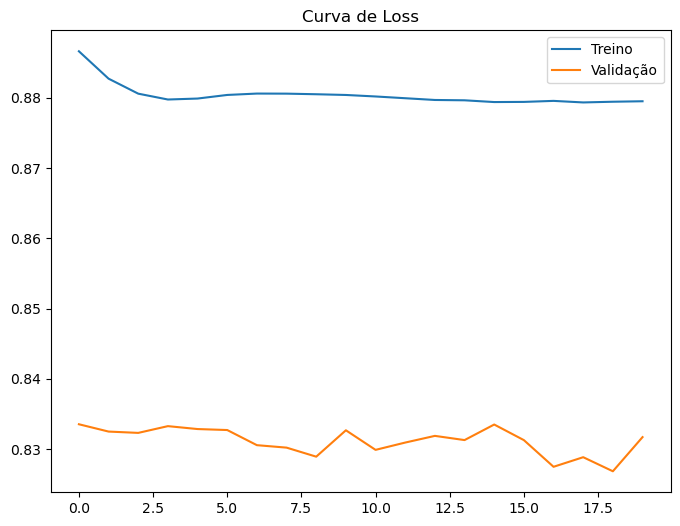

In [26]:
epochs = MODEL_CONFIG["epochs"]
train_hist, val_hist = [], []

print("Iniciando Treinamento GRU...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            val_loss += criterion(model(Xv), yv).item()
            
    mean_train = epoch_loss/len(train_loader)
    mean_val = val_loss/len(val_loader)
    train_hist.append(mean_train)
    val_hist.append(mean_val)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {mean_train:.5f} | Val Loss: {mean_val:.5f}")

# Salvar Modelo
torch.save(model.state_dict(), "gru_model.pth")
print("\nModelo GRU salvo!")

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_hist, label='Treino')
plt.plot(val_hist, label='Validação')
plt.title("Curva de Loss")
plt.legend()
plt.show()

### TESTE E AVALIAÇÃO

In [27]:
test_year_mask = df["year"] == 2020 
test_days_mask = df["day"].between(test_start, test_end)
df_source = df[test_year_mask & test_days_mask].copy().sort_values(by=["latitude", "longitude", "year", "day"])

meta_rows = []
grouped = df_source.groupby(["latitude", "longitude"])

seq_len_eval = MODEL_CONFIG["seq_len"]

for (lat, lon), group in grouped:
    group = group.sort_values(by=["year", "day"])
    total_len = len(group)
    if total_len < (seq_len_eval + 30): continue
    
    for i in range(0, total_len - seq_len_eval - 30 + 1, 1):
        target_slice = group.iloc[i + seq_len_eval : i + seq_len_eval + 30]
        for _, row in target_slice.iterrows():
            meta_rows.append({
                "latitude": lat, 
                "longitude": lon,
                "tp": row["tp"],        
                "month": row["month"],  
                "year": row["year"],    
                "day": row["day"]       
            })

df_test = pd.DataFrame(meta_rows)

PREVISÃO

In [28]:
model.eval()
with torch.no_grad():
    pred_test_scaled = model(X_test.to(device)).cpu().numpy()

#desnormalização
pred_test_flat = scaler_y_train.inverse_transform(pred_test_scaled.reshape(-1, 1)).flatten()

# Alinhamento
min_len = min(len(df_test), len(pred_test_flat))
df_pred = df_test.iloc[:min_len].copy()
df_pred["tp_pred"] = pred_test_flat[:min_len]

MÉTRICAS

In [29]:
obs = df_pred['tp'].values
pred = df_pred['tp_pred'].values

mse = mean_squared_error(obs, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(obs, pred)
me = np.mean(obs - pred)

print("\n===== Métricas de Erro =====")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"MSE:    {mse:.4f}")

threshold = 0.01
obs_evt = (obs >= threshold).astype(int)
pred_evt = (pred >= threshold).astype(int)
hits = np.sum((obs_evt == 1) & (pred_evt == 1))
misses = np.sum((obs_evt == 1) & (pred_evt == 0))
false_al = np.sum((obs_evt == 0) & (pred_evt == 1))

POD = hits / (hits + misses + 1e-9)
FAR = false_al / (hits + false_al + 1e-9)
CSI = hits / (hits + misses + false_al + 1e-9)

print(f"\n===== Métricas de Evento (≥ {threshold} mm) =====")
print(f"POD:  {POD:.4f}")
print(f"FAR:  {FAR:.4f}")
print(f"CSI:  {CSI:.4f}")


===== Métricas de Erro =====
RMSE:  0.0784
MAE:   0.0600
MSE:    0.0062

===== Métricas de Evento (≥ 0.01 mm) =====
POD:  1.0000
FAR:  0.8292
CSI:  0.1708


MAPAS

In [30]:
#Média da Previsão e da Observação (Do ano atual, 2020)
df_medias = df_pred.groupby(["latitude", "longitude"])[["tp", "tp_pred"]].mean().reset_index()

# Média Histórica 2010-2018 APENAS DO MÊS ALVO
target_months = df_pred["month"].unique()

# Filtra o histórico para pegar apenas esses meses
hist_mask = (df["year"].isin(range(2010, 2018))) & (df["month"].isin(target_months))
df_hist = df[hist_mask].groupby(["latitude", "longitude"])["tp"].mean().reset_index()

# Unir Previsão 2020 com Histórico
df_medias = pd.merge(df_medias, df_hist, on=["latitude", "longitude"], suffixes=("", "_hist"))

if "tp_y" in df_medias.columns:
    df_medias.rename(columns={"tp_y": "tp_hist", "tp_x": "tp"}, inplace=True)
elif "tp_hist" not in df_medias.columns:
    df_medias["tp_hist"] = df_medias["tp"] 

df_medias["error"] = df_medias["tp_pred"] - df_medias["tp"]

# Função Auxiliar para DataArray
def df_to_da(dframe, col):
    grid = dframe.pivot_table(index="latitude", columns="longitude", values=col)
    return xr.DataArray(grid.values, coords=[grid.index, grid.columns], dims=["latitude", "longitude"])

da_tp = df_to_da(df_medias, "tp")
da_pred = df_to_da(df_medias, "tp_pred")
da_hist = df_to_da(df_medias, "tp_hist")
da_error = df_to_da(df_medias, "error")

#Calcular percentil
p10 = np.percentile(df_medias["tp_hist"], 10)
p90 = np.percentile(df_medias["tp_hist"], 90)
print("Percentil 10", p10)
print("Percentil 90", p90)

Percentil 10 0.00092173094
Percentil 90 0.08791017


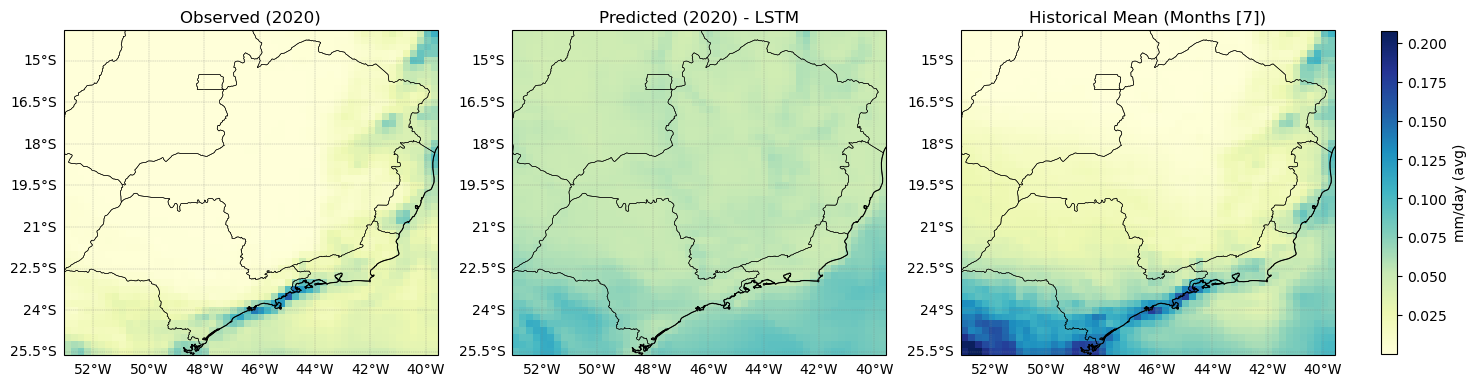

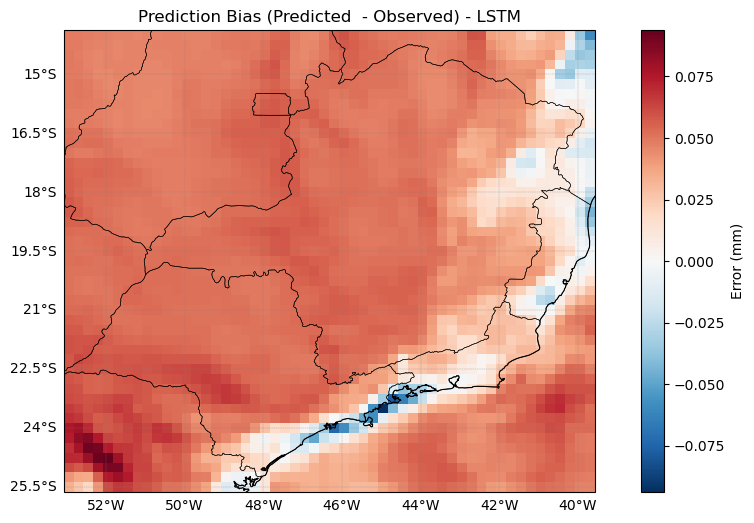

In [31]:
def add_map_features(ax):
    """Adicionar fronteiras e estados."""
    try:
        ax.coastlines(resolution='10m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.4) 
    except Exception:
        try:
            ax.coastlines(resolution='110m') 
            ax.add_feature(cfeature.BORDERS, linestyle=':')
        except: pass
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# Plot 1: Comparativo (Obs vs Previsto vs Histórico do Mês)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
datas = [da_tp, da_pred, da_hist]
titles = ["Observed (2020)", "Predicted (2020) - LSTM", f"Historical Mean (Months {target_months})"]

# Define escala baseada no histórico para comparação justa
vmin = float(da_hist.min())
vmax = float(da_hist.max())

for ax, da, title in zip(axes, datas, titles):
    img = da.plot(ax=ax, cmap="YlGnBu", vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title(title)
    add_map_features(ax)

cbar = fig.colorbar(img, ax=axes, shrink=0.7, pad=0.03)
cbar.set_label("mm/day (avg)")
plt.show()

# Plot 2: Erro
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
abs_max = float(max(abs(da_error.min()), abs(da_error.max())))

da_error.plot(
    ax=ax, cmap="RdBu_r", vmin=-abs_max, vmax=abs_max,
    transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Error (mm)'}
)
ax.set_title(f"Prediction Bias (Predicted  - Observed) - LSTM")
add_map_features(ax)
plt.show()